### Packages

In [1]:
!pip install keras-tuner --quiet

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount(mountpoint='/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from datetime import datetime
from IPython.display import display
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import style
from tqdm import tqdm

In [5]:
from skimage.util.shape import view_as_blocks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
import os
import re

In [7]:
import cv2 as cv
import keras_tuner as kt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [8]:
style.use(style='seaborn-deep')

### Data

In [12]:
tr_path = "/content/dataset/train"
te_path = "/content/dataset/test"

In [13]:
tr_images = glob(pathname=(tr_path + '/*jpeg'))
te_images = glob(pathname=(te_path + '/*jpeg'))

In [14]:
tr_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), tr_images))
te_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), te_images))

In [15]:
(tr_images,
 cv_images,
 tr_labels,
 cv_labels) = train_test_split(tr_images, tr_labels, test_size=0.20, random_state=0)

In [16]:
print(len(tr_images), len(tr_labels))
print(len(cv_images), len(cv_labels))
print(len(te_images), len(te_labels))

64000 64000
16000 16000
20000 20000


### Preprocessing

Preprocess a single image for visualization

In [17]:
def preprocess_input_image(imagefile, resize_scale=(200, 200)):
    """
    This function preprocesses in the input image.
    """
    rows, cols = (8, 8)
    img = cv.imread(filename=imagefile)
    img = cv.resize(src=img, dsize=resize_scale)
    h, w, c = img.shape
    square = h // rows # 200 // 8 = 50
    # Below line of code returns an image in blocks. Shape: (8, 8, 1, 25, 25, 3).
    img_blocks = view_as_blocks(arr_in=img, block_shape=(square, square, c))
    # Below line of code reshapes the image blocks. Shape: (64, 25, 25, 3).
    # In a chessboard, there are 64 squares and each square is of shape (25, 25, 3).
    img_blocks = img_blocks.reshape(rows * cols, square, square, c)
    return img_blocks

In [18]:
def visualize_preprocessed_image(imagefile):
    """
    This function is for better understanding the preprocessing step.
    """
    c = 8
    r = 8

    img = cv.imread(filename=imagefile)

    print("Input: Chess image\n")
    plt.figure(figsize=(r, c))
    plt.imshow(X=img)
    plt.axis('off')
    plt.show()

    img_blocks = preprocess_input_image(imagefile=imagefile)
    fig = plt.figure(figsize=(r, c))
    print("\nPreprocessed: Chess image broken into 64 squares\n")
    for i, img_block in enumerate(img_blocks):
        fig.add_subplot(r, c, i+1)
        plt.imshow(X=img_block)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

Input: Chess image



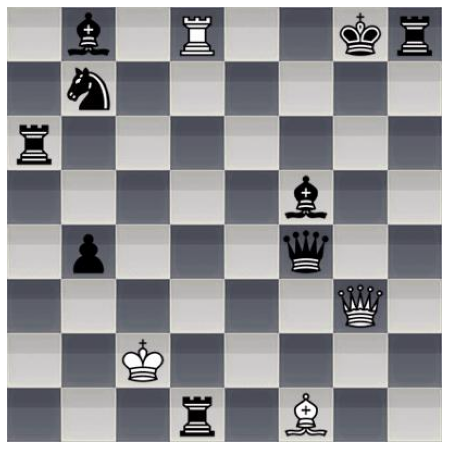


Preprocessed: Chess image broken into 64 squares



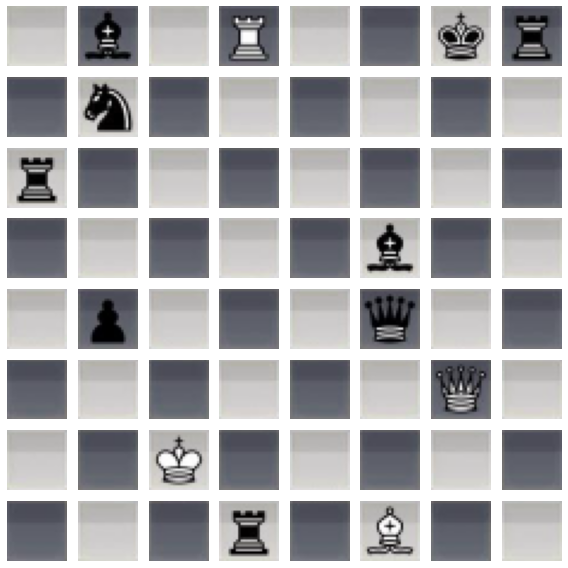

In [19]:
imagefile = random.choice(seq=tr_images)
visualize_preprocessed_image(imagefile=imagefile)

### Modeling

In [20]:
import tensorflow as tf

In [21]:
from tensorflow.keras.layers import (
    Conv2D,
    Flatten, 
    Dense, 
    Dropout,
    Input
)

from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback
)

from tensorflow.keras.models import Model

In [22]:
def plot_model_performance(tracker_df):
    """
    This function plots the performance of the model.
    """
    plt.figure(figsize=(18, 6))
    x = tracker_df.index

    plt.subplot(131)
    plt.plot(x, tracker_df['accuracy'].values, 'r--', label='train')
    plt.plot(x, tracker_df['val_accuracy'].values, 'g--', label='validation')
    plt.title('Accuracy Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(132)
    plt.plot(x, tracker_df['loss'].values, 'r--', label='train')
    plt.plot(x, tracker_df['val_loss'].values, 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.show()

#### Data pipeline

In [23]:
class DataPipeline(object):
    """
    This class is a data pipeline for deep learning model.
    """

    def __init__(self, tr_images, tr_labels, cv_images, cv_labels, te_images, te_labels):
        self.rows, self.cols = (8, 8)
        self.square = None
        self.h, self.w, self.c = None, None, None
        self.N = 13
        self.tr_images = np.array(tr_images)
        self.tr_labels = np.array(tr_labels)
        self.cv_images = np.array(cv_images)
        self.cv_labels = np.array(cv_labels)
        self.te_images = np.array(te_images)
        self.te_labels = np.array(te_labels)
        self.piece_symbols = 'prbnkqPRBNKQ'
    
    def preprocess_input_image(self, imagefile, resize_scale=(200, 200)):
        """
        This function preprocesses in the input image.
        """
        img = cv.imread(filename=imagefile)
        img = cv.resize(src=img, dsize=resize_scale)

        self.h, self.w, self.c = img.shape
        self.square = self.h // self.rows

        img_blocks = view_as_blocks(
            arr_in=img, block_shape=(self.square, self.square, self.c))
        img_blocks = img_blocks.reshape(
            self.rows * self.cols, self.square, self.square, self.c)
        
        return img_blocks
    
    def tr_data_generator(self):
        """
        This method preprocess the input images.
        """
        for i, l in zip(self.tr_images, self.tr_labels):
            yield (self.preprocess_input_image(imagefile=i),
                   self.onehot_from_fen(fen=l))
    
    def cv_data_generator(self):
        """
        This method preprocess the input images.
        """
        for i, l in zip(self.cv_images, self.cv_labels):
            yield (self.preprocess_input_image(imagefile=i),
                   self.onehot_from_fen(fen=l))
    
    def te_data_generator(self):
        """
        This method preprocess the input targets.
        """
        for i in self.te_images:
            yield self.preprocess_input_image(imagefile=i)
    
    def onehot_from_fen(self, fen):
        """
        This function converts FEN to onehot.
        The original author of this method is 'PAVEL KORYAKIN'.
        PAVEL KORYAKIN is also the maintainer of Chess Positions dataset.
        """
        eye = np.eye(N=self.N)
        output = np.empty(shape=(0, self.N))
        fen = re.sub(pattern='[/]', repl='', string=fen)

        for char in fen:
            if char in '12345678':
                output = np.append(
                    arr=output,
                    values=np.tile(A=eye[self.N-1], reps=(int(char), 1)), axis=0
                )
            else:
                idx = self.piece_symbols.index(char)
                output = np.append(
                    arr=output,
                    values=eye[idx].reshape((1, self.N)), axis=0
                )
        
        return output
    
    def fen_from_onehot(self, onehot):
        """
        This function converts onehot to FEN.
        The original author of this method is 'PAVEL KORYAKIN'.
        PAVEL KORYAKIN is also the maintainer of Chess Positions dataset.
        """
        output = str()
        for j in range(self.rows):
            for i in range(self.cols):
                if onehot[j][i] == 12:
                    output += ' '
                else:
                    output += self.piece_symbols[int(onehot[j][i])]
            if j != 7:
                output += '/'
        
        for i in range(8, 0, -1):
            output = output.replace(' ' * i, str(i))
        
        return output
    
    def construct_dataset(self):
        """
        This method constructs the dataset.
        """
        tr_dataset = tf.data.Dataset.from_generator(
            generator=self.tr_data_generator, output_types=(tf.int64, tf.int64))
        tr_dataset = tr_dataset.repeat()

        cv_dataset = tf.data.Dataset.from_generator(
            generator=self.cv_data_generator, output_types=(tf.int64, tf.int64))
        cv_dataset = cv_dataset.repeat()

        te_dataset = tf.data.Dataset.from_generator(
            generator=self.te_data_generator, output_types=tf.int64)
        te_dataset = te_dataset.repeat()

        it_tr = tr_dataset.__iter__()
        it_cv = cv_dataset.__iter__()
        it_te = te_dataset.__iter__()

        return it_tr, it_cv, it_te

In [24]:
data_pipe = DataPipeline(tr_images=tr_images,
                         tr_labels=tr_labels,
                         cv_images=cv_images,
                         cv_labels=cv_labels,
                         te_images=te_images,
                         te_labels=te_labels)

In [25]:
tr_dataset, cv_dataset, te_dataset = data_pipe.construct_dataset()

#### Chess base model - tuner and fitter

In [26]:
class ChessModel(object):
    """
    This class is for deep learning model for chess recognition problem.
    """

    def __init__(self,
                 tr_dataset,
                 cv_dataset,
                 tr_size,
                 cv_size,
                 filepath_tuner,
                 filepath_fitter,
                 filepath_tracker):
        self.tr_dataset = tr_dataset
        self.cv_dataset = cv_dataset
        self.input_shape = (25, 25, 3)
        self.batch_size = 64
        self.output_units = 13 # 12 for chess pieces and 1 for empty square.
        self.tr_size = tr_size
        self.cv_size = cv_size
        self.filepath_tuner = filepath_tuner
        self.filepath_fitter = filepath_fitter
        self.filepath_tracker = filepath_tracker
    
    def build_model(self, hp):
        """
        This method builds the optimized model.
        """
        hp_activations = hp.Choice(
            name='activation', values=['relu', 'tanh', 'sigmoid'])
        hp_filters_1 = hp.Int(
            name='filter_1', min_value=32, max_value=64, step=10)
        hp_filters_2 = hp.Int(
            name='filter_2', min_value=32, max_value=64, step=10)
        hp_kernel_1 = hp.Int(
            name='Kernel_1', min_value=2, max_value=5, step=None)
        hp_kernel_2 = hp.Int(
            name='Kernel_2', min_value=2, max_value=5, step=None)
        hp_units = hp.Int(
            name='dense', min_value=32, max_value=64, step=10)
        hp_learning_rate = hp.Choice(
            name='learning_rate', values=[1e-2, 1e-3, 1e-4])

        input_layer = Input(
            shape=self.input_shape, batch_size=self.batch_size, name='Input')
        conv_2d_layer_1 = Conv2D(
            filters=hp_filters_1, kernel_size=hp_kernel_1,
            activation=hp_activations, name='Conv2D_1')(input_layer)
        conv_2d_layer_2 = Conv2D(
            filters=hp_filters_2, kernel_size=hp_kernel_2,
            activation=hp_activations, name='Conv2D_2')(conv_2d_layer_1)
        flatten_layer = Flatten(name='Flatten')(conv_2d_layer_2)
        dense_layer = Dense(
            units=hp_units, activation=hp_activations, name='Dense')(flatten_layer)
        output_layer = Dense(
            units=self.output_units, activation='softmax', name='Output')(dense_layer)
        
        model = Model(inputs=input_layer, outputs=output_layer, name='Chess_Model')

        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        model.compile(
            optimizer=optimizer, loss='categorical_crossentropy',
            metrics=['accuracy'])
        
        return model
    
    def model_tuner(self):
        """
        This method tunes the chess model.
        """
        if not os.path.isfile(path=self.filepath_tuner):
            print("Tuning the model.")
            stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
            tuner = kt.Hyperband(
                hypermodel=self.build_model, objective='val_accuracy', max_epochs=10)
            tuner.search(
                x=tr_dataset, epochs=50, steps_per_epoch=self.tr_size,
                validation_data=cv_dataset, validation_steps=self.cv_size,
                callbacks=[stop_early])
            print("Tuning completed.")
            
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hps)
            tf.keras.models.save_model(model=model, filepath=self.filepath_tuner)
            print("Saved the best model to the file.")
        else:
            print("Model is already tuned, and is also saved.")
            model = tf.keras.models.load_model(filepath=self.filepath_tuner)
            print("Loaded the tuned model and ready for fitting.")

        return model
    
    def model_fitter(self):
        """
        This method fits the tuned model.
        """
        model = self.model_tuner()
        print()
        model.summary()
        print()

        model_save_callback = ModelCheckpoint(
            filepath=self.filepath_fitter, monitor='val_accuracy',
            verbose=1, save_best_only=True, mode='auto')
        callbacks = [model_save_callback]

        if not os.path.isfile(path=self.filepath_fitter):
            print("Fitting the model.")

            epochs = 10
            tracker = model.fit(
                x=tr_dataset, validation_data=cv_dataset, epochs=epochs,
                steps_per_epoch=len(tr_images), validation_steps=len(cv_images),
                callbacks=callbacks)
            print("\nSaved the fitted model.")
            
            tracker_df = pd.DataFrame(data=tracker.history)
            tracker_df.to_csv(path_or_buf=self.filepath_tracker, index=False)
            print("Saved the history to the file.")
        else:
            print("Model is already fitted, and is also saved.")
            model = tf.keras.models.load_model(filepath=self.filepath_fitter)
            print("Loaded the fitted model and ready for prediction.")
            
            tracker_df = pd.read_csv(filepath_or_buffer=self.filepath_tracker)
        
        print()
        plot_model_performance(tracker_df=tracker_df)

        return model

In [27]:
tr_size = len(tr_images)
cv_size = len(cv_images)
te_size = len(te_images)
filepath_tuner = "/content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/tuned_model.h5.h5"
filepath_fitter = "/content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/tuned_fitted_model.h5"
filepath_tracker = "/content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/tracker.csv"

In [28]:
ch_obj = ChessModel(
    tr_dataset=tr_dataset, cv_dataset=cv_dataset, tr_size=tr_size, cv_size=cv_size,
    filepath_tuner=filepath_tuner,
    filepath_fitter=filepath_fitter,
    filepath_tracker=filepath_tracker)

Model is already tuned, and is also saved.
Loaded the tuned model and ready for fitting.

Model: "Chess_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(64, 25, 25, 3)]         0         
                                                                 
 Conv2D_1 (Conv2D)           (64, 21, 21, 32)          2432      
                                                                 
 Conv2D_2 (Conv2D)           (64, 19, 19, 62)          17918     
                                                                 
 Flatten (Flatten)           (64, 22382)               0         
                                                                 
 Dense (Dense)               (64, 42)                  940086    
                                                                 
 Output (Dense)              (64, 13)                  559       
                               

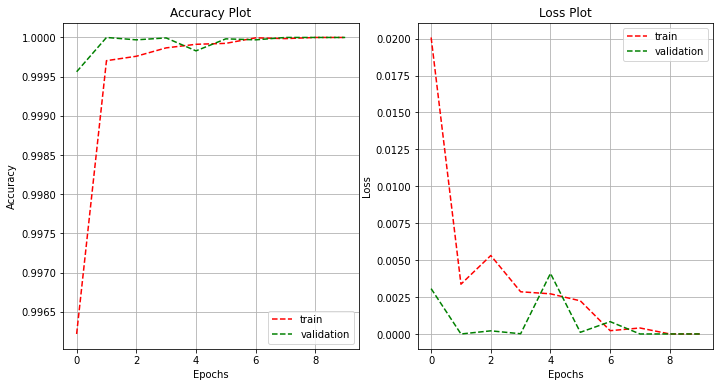

In [29]:
model = ch_obj.model_fitter()

#### All images prediction

In [30]:
result = model.predict(x=te_dataset, steps=len(te_images))

20000/20000 [==============================] - 91s 4ms/step


In [31]:
result = result.argmax(axis=1)
result = result.reshape(-1, 8, 8)

In [32]:
pr_labels = list(map(data_pipe.fen_from_onehot, result))

In [33]:
te_labels, pr_labels = np.array(te_labels), np.array(pr_labels)

In [34]:
base_model_acc = (te_labels == pr_labels).astype(float).mean() * 100
print(f"Base model accuracy: {round(base_model_acc, 3)}%")

Base model accuracy: 100.0%


#### Single image prediction

In [35]:
test_index = random.choice(range(0, len(te_images)))
print(f"Actual FEN: {te_labels[test_index]}")

Actual FEN: 8/4q3/2nB4/2R5/4kP1b/7r/2P5/3K1R2


In [39]:
pred = model.predict(x=data_pipe.preprocess_input_image(te_images[test_index])).argmax(axis=1).reshape(-1, 8, 8)
pred = data_pipe.fen_from_onehot(onehot=pred[0])
print(f"Predicted FEN: {pred}")

2/2 [==============================] - 0s 5ms/step
Predicted FEN: 8/4q3/2nB4/2R5/4kP1b/7r/2P5/3K1R2


#### Confusion matrix

In [40]:
cmat = confusion_matrix(y_true=te_labels, y_pred=pr_labels)

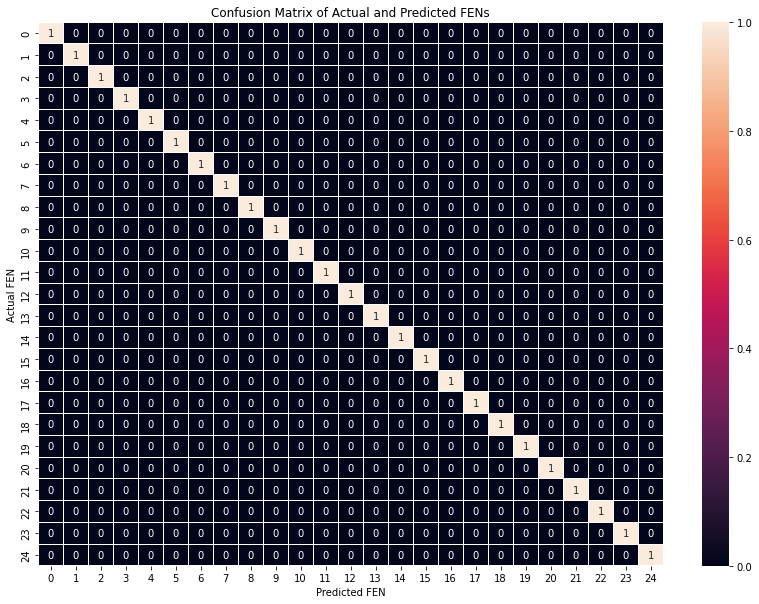

In [49]:
plt.figure(figsize=(14, 10))
sns.heatmap(data=cmat[:25, :25], annot=True, linewidths=0.1)
plt.xlabel(xlabel='Predicted FEN')
plt.ylabel(ylabel='Actual FEN')
plt.title(label='Confusion Matrix of Actual and Predicted FENs')
plt.show()